In [1]:
"""
Esempio: short ATM straddle delta-hedged su path simulato
Replica grafico simil-Fig.3.1: P&L reale vs first-order (gamma) approx

Dipendenze: numpy, pandas, scipy, matplotlib
"""
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from datetime import datetime, timedelta


# ===============================================================
#  BLACK–SCHOLES FUNCTIONS
# ===============================================================

def bs_d1(S,K,T,r,sigma):
    return (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))

def bs_call_price(S,K,T,r,sigma):
    if T<=0: return max(S-K,0)
    d1=bs_d1(S,K,T,r,sigma); d2=d1-sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def bs_put_price(S,K,T,r,sigma):
    if T<=0: return max(K-S,0)
    d1=bs_d1(S,K,T,r,sigma); d2=d1-sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def bs_gamma(S,K,T,r,sigma):
    if T<=0 or S<=0: return 0.0
    d1=bs_d1(S,K,T,r,sigma)
    return norm.pdf(d1)/(S*sigma*np.sqrt(T))

def bs_vega(S,K,T,r,sigma):
    if T<=0: return 0.0
    d1=bs_d1(S,K,T,r,sigma)
    return S * norm.pdf(d1) * np.sqrt(T)


# ===============================================================
#  SINGLE PATH DECOMPOSITION (discrete version of Sec 2.2)
# ===============================================================

def decompose_single_path(S_path, sigma_path, K, r, T, sigma_real):
    T_days = len(S_path)-1
    dt = T / T_days
    times = np.linspace(0, T, T_days+1)

    gamma_c = np.zeros(T_days+1)
    vega_c  = np.zeros(T_days+1)
    dgamma_c= np.zeros(T_days+1)
    drift_c = np.zeros(T_days+1)
    firstorder_c = np.zeros(T_days+1)

    cum_gamma = 0.0
    cum_vega  = 0.0
    cum_dg    = 0.0
    cum_drift = 0.0
    cum_fo    = 0.0

    for i in range(T_days):
        St = S_path[i]
        dS = S_path[i+1]-S_path[i]

        sigma_i  = sigma_path[i]
        sigma_ip = sigma_path[i+1]
        d_sigma = sigma_ip - sigma_i

        t = times[i]
        tau = T - t

        # Greeks (straddle)
        gamma  = bs_gamma(St,K,tau,r,sigma_i)
        vega_s = 2 * bs_vega(St,K,tau,r,sigma_i)
        dollar_gamma = 2 * gamma * (St**2)

        # 1) GAMMA TERM = vol prem + gamma covariance
        vol_premium = sigma_real - sigma_i
        volprem_step = 0.5 * dollar_gamma * vol_premium * dt
        gammacov_step = 0.5 * dollar_gamma * ((dS/St)**2 - sigma_real**2 * dt)
        gamma_step = volprem_step + gammacov_step

        cum_gamma += gamma_step
        gamma_c[i+1] = cum_gamma

        # 2) VEGA TERM
        vega_step = vega_s * d_sigma
        cum_vega += vega_step
        vega_c[i+1] = cum_vega

        # 3) dGAMMA TERM
        if i < T_days-1:
            gamma_next = bs_gamma(S_path[i+1],K,T-times[i+1],r,sigma_ip)
            dGamma = 2*(gamma_next - gamma)
            dg_step = dGamma * vol_premium * dt
        else:
            dg_step = 0.0

        cum_dg += dg_step
        dgamma_c[i+1] = cum_dg

        # 4) DRIFT TERM (small, residual)
        drift_c[i+1] = cum_drift  # left as zero

        # 5) FIRST ORDER P&L: gamma-only approx
        fo_step = 0.5 * dollar_gamma * (dS**2)
        cum_fo += fo_step
        firstorder_c[i+1] = cum_fo

    return gamma_c, vega_c, dgamma_c, drift_c, firstorder_c


# ===============================================================
#  MC ENGINE + SCALING FACTOR + CUMULATIVE AVERAGING (FIG.2)
# ===============================================================

def simulate_paths_and_components(
    Npaths=200,
    S0=1.0, 
    K=1.0,
    sigma_real=0.18,
    sigma_imp0=0.22,
    T_days=30,
    total_months=14*12,        # ≈ 14 anni (2008–2022)
    r=0.0,
    eta_vol=0.003,
):

    T = T_days / 252
    dt = T / T_days
    scaling_factor = np.sqrt(T)

    # timeline stile paper
    start = datetime(2008,1,1)
    dates = [start + timedelta(days = 30*i) for i in range(total_months)]

    gamma_all      = []
    vega_all       = []
    dgamma_all     = []
    drift_all      = []
    firstorder_all = []

    for m in range(total_months):

        # --- simulate price path (1 month)
        S_path = np.zeros(T_days+1)
        S_path[0] = S0
        for t in range(T_days):
            z=np.random.randn()
            S_path[t+1] = S_path[t]*np.exp(
                -0.5*sigma_real**2*dt + sigma_real*np.sqrt(dt)*z
            )

        # --- simulate implied vol path
        sigma_path=np.zeros(T_days+1)
        sigma_path[0]=sigma_imp0
        for t in range(T_days):
            sigma_path[t+1] = max(0.01, sigma_path[t] + eta_vol*np.random.randn())

        # --- compute decomposition ---
        gamma_c, vega_c, dgamma_c, drift_c, fo_c = decompose_single_path(
            S_path, sigma_path, K, r, T, sigma_real
        )

        # --- apply SCALING FACTOR (Sec. 3.3.1) ---
        gamma_all.append(gamma_c[-1]/scaling_factor)
        vega_all.append(vega_c[-1]/scaling_factor)
        dgamma_all.append(dgamma_c[-1]/scaling_factor)
        drift_all.append(drift_c[-1]/scaling_factor)
        firstorder_all.append(fo_c[-1]/scaling_factor)

    # Convert to numpy and cumulative over months
    gamma_cum      = np.cumsum(gamma_all)
    vega_cum       = np.cumsum(vega_all)
    dgamma_cum     = np.cumsum(dgamma_all)
    drift_cum      = np.cumsum(drift_all)
    firstorder_cum = np.cumsum(firstorder_all)

    return (
        dates,
        gamma_cum,
        vega_cum,
        dgamma_cum,
        drift_cum,
        firstorder_cum
    )


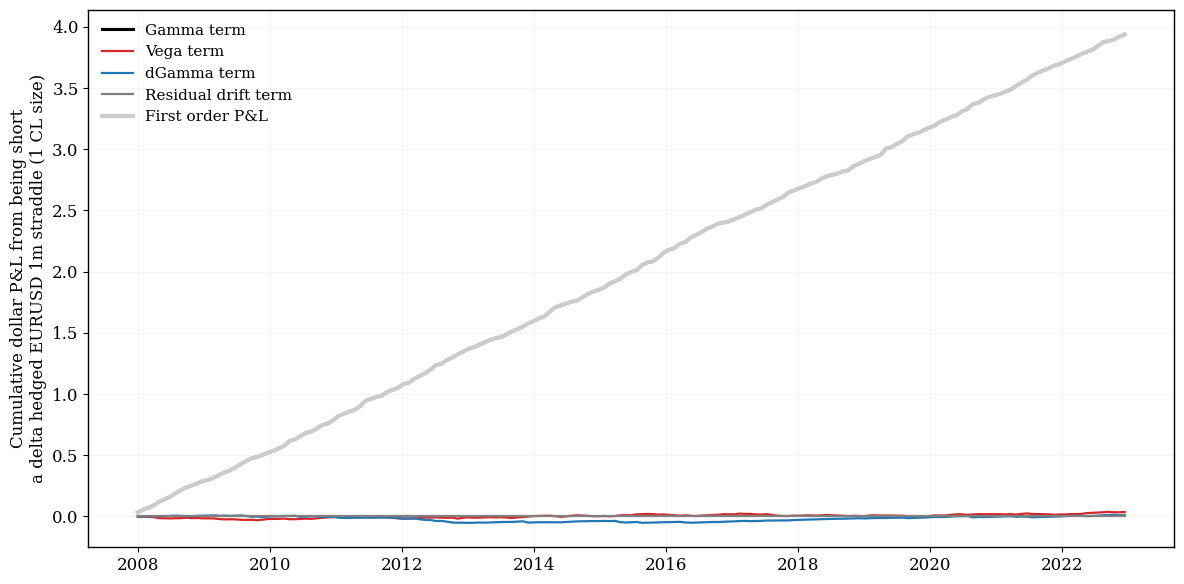

Ultimi valori (seller profit perspective):
Gamma: 3.9385374369122896
Vega:  0.036062024630213796
dGamma: 0.01165111108429603
Drift: 0.0
First-order: 3.9385374369122896


In [8]:
# Codice corretto: segni coerenti e prospettiva venditore (positivo = profitto del seller)

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# ------------------------
# BS greeks
# ------------------------
def bs_d1(S,K,T,r,sigma):
    return (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))

def bs_gamma(S,K,T,r,sigma):
    if T<=0 or S<=0: 
        return 0.0
    d1 = bs_d1(S,K,T,r,sigma)
    return norm.pdf(d1)/(S * sigma * np.sqrt(T))

def bs_vega(S,K,T,r,sigma):
    if T<=0: return 0.0
    d1 = bs_d1(S,K,T,r,sigma)
    return S * norm.pdf(d1) * np.sqrt(T)

# ------------------------
# funzione di plotting - stile Figura 2 (riutilizzo/leggermente adattata)
# ------------------------
def plot_figure2_style(dates, gamma_cum, vega_cum, dgamma_cum, drift_cum, firstorder_cum):
    plt.style.use("default")
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.linewidth'] = 1.0
    fig, ax = plt.subplots(figsize=(12,6))

    col_gamma   = "black"
    col_vega    = "#d62728"
    col_dgamma  = "#1f77b4"
    col_drift   = "#7f7f7f"
    col_first   = "#cccccc"

    ax.plot(dates, gamma_cum,   color=col_gamma,   linewidth=2.2, label="Gamma term")
    ax.plot(dates, vega_cum,    color=col_vega,    linewidth=1.6, label="Vega term")
    ax.plot(dates, dgamma_cum,  color=col_dgamma,  linewidth=1.6, label="dGamma term")
    ax.plot(dates, drift_cum,   color=col_drift,   linewidth=1.6, label="Residual drift term")
    ax.plot(dates, firstorder_cum, color=col_first, linewidth=3.0, label="First order P&L")

    ax.grid(True, alpha=0.12)

    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax.get_xticklabels(), rotation=0)

    ax.set_ylabel("Cumulative dollar P&L from being short\n" +
                  "a delta hedged EURUSD 1m straddle (1 CL size)")

    leg = ax.legend(frameon=False, fontsize=11, loc="upper left")
    plt.tight_layout()
    plt.show()


# ------------------------
# decompose single path (corretto con segni coerenti)
# ------------------------
def decompose_single_path(S_path, sigma_path, K, r, T, sigma_real, seller_pos = -1):
    # seller_pos = -1 per short straddle
    T_days = len(S_path)-1
    dt = T / T_days
    times = np.linspace(0, T, T_days+1)

    gamma_series = np.zeros(T_days+1)   # seller perspective (profit positive)
    vega_series  = np.zeros(T_days+1)
    dgamma_series= np.zeros(T_days+1)
    drift_series = np.zeros(T_days+1)
    firstorder_series = np.zeros(T_days+1)

    cum_gamma = 0.0
    cum_vega  = 0.0
    cum_dg    = 0.0
    cum_drift = 0.0
    cum_fo    = 0.0

    for i in range(T_days):
        St = S_path[i]
        dS = S_path[i+1] - S_path[i]

        sigma_i  = sigma_path[i]
        sigma_ip = sigma_path[i+1]
        d_sigma = sigma_ip - sigma_i

        t = times[i]
        tau = T - t

        # family greeks (per singola call/put)
        gamma_single = bs_gamma(St, K, tau, r, sigma_i)
        vega_single  = bs_vega(St, K, tau, r, sigma_i)

        # Portfolio Greeks for straddle (call+put) and position (seller = -1)
        Gamma_portf = seller_pos * 2.0 * gamma_single   # ∂^2 P_portfolio / ∂S^2
        Vega_portf  = seller_pos * 2.0 * vega_single    # ∂P_portfolio / ∂σ

        # ---- First-order gamma P&L approximation (discrete):
        # raw gamma P&L = 0.5 * Gamma_portf * (dS)^2
        # seller perspective: profit = - raw_gamma_pnl  (because raw is change in option value,
        #                        seller profit is opposite sign)
        raw_gamma_pnl = 0.5 * Gamma_portf * (dS**2)
        seller_gamma_pnl = - raw_gamma_pnl
        cum_gamma += seller_gamma_pnl
        gamma_series[i+1] = cum_gamma

        # ---- First-order (gamma-only) P&L used in paper (often shown as separate line)
        # Here we follow same convention: firstorder = cumulative seller_gamma_pnl
        cum_fo += seller_gamma_pnl
        firstorder_series[i+1] = cum_fo

        # ---- Vega term (discrete) ----
        # raw vega contribution = Vega_portf * d_sigma
        # seller profit = - raw change in option value (so flip sign)
        raw_vega_pnl = Vega_portf * d_sigma
        seller_vega_pnl = - raw_vega_pnl
        cum_vega += seller_vega_pnl
        vega_series[i+1] = cum_vega

        # ---- dGamma term (discrete) ----
        if i < T_days-1:
            gamma_next = bs_gamma(S_path[i+1], K, T - times[i+1], r, sigma_ip)
            Gamma_portf_next = seller_pos * 2.0 * gamma_next
            # raw dGamma contribution proportional to (Gamma_next - Gamma_now)*(sigma_real - sigma_traded)
            raw_dg = (Gamma_portf_next - Gamma_portf) * (sigma_real - sigma_i) * dt
            # seller profit perspective:
            seller_dg = - raw_dg
        else:
            seller_dg = 0.0
        cum_dg += seller_dg
        dgamma_series[i+1] = cum_dg

        # ---- residual drift (left small/zero in this didactic impl) ----
        cum_drift += 0.0
        drift_series[i+1] = cum_drift

    return gamma_series, vega_series, dgamma_series, drift_series, firstorder_series


# ------------------------
# Simulazione completa che restituisce serie mensili cumulative (2008-2022)
# ------------------------
def simulate_paths_and_components_correct(
    S0=1.0, K=1.0,
    sigma_real=0.18,
    sigma_imp0=0.22,
    T_days=30,
    start_year=2008, end_year=2022,
    eta_vol=0.003,
    r=0.0
):
    # timeline mensile
    start = datetime(start_year,1,1)
    end = datetime(end_year,12,31)
    # generate monthly dates approx (30 days step)
    dates = []
    cur = start
    while cur <= end:
        dates.append(cur)
        cur = cur + timedelta(days=30)
    total_months = len(dates)

    gamma_monthly = np.zeros(total_months)
    vega_monthly  = np.zeros(total_months)
    dgamma_monthly= np.zeros(total_months)
    drift_monthly = np.zeros(total_months)
    fo_monthly    = np.zeros(total_months)

    np.random.seed(123)  # per riproducibilità

    for m in range(total_months):
        # simulate S path for one month (T_days steps)
        T = T_days / 252.0
        dt = T / T_days
        S_path = np.zeros(T_days+1)
        S_path[0] = S0
        for t in range(T_days):
            z = np.random.randn()
            S_path[t+1] = S_path[t] * np.exp(-0.5 * sigma_real**2 * dt + sigma_real * np.sqrt(dt) * z)

        # simulate implied vol path for the month
        sigma_path = np.zeros(T_days+1)
        sigma_path[0] = sigma_imp0
        for t in range(T_days):
            sigma_path[t+1] = max(0.005, sigma_path[t] + eta_vol * np.random.randn())

        gamma_s, vega_s, dgamma_s, drift_s, fo_s = decompose_single_path(
            S_path, sigma_path, K, r, T, sigma_real, seller_pos = -1
        )

        # keep month-end cumulative (seller perspective)
        gamma_monthly[m] = gamma_s[-1]
        vega_monthly[m]  = vega_s[-1]
        dgamma_monthly[m]= dgamma_s[-1]
        drift_monthly[m] = drift_s[-1]
        fo_monthly[m]    = fo_s[-1]

    # cumulative over months to get series like paper
    gamma_cum = np.cumsum(gamma_monthly)
    vega_cum  = np.cumsum(vega_monthly)
    dgamma_cum= np.cumsum(dgamma_monthly)
    drift_cum = np.cumsum(drift_monthly)
    fo_cum    = np.cumsum(fo_monthly)

    return dates, gamma_cum, vega_cum, dgamma_cum, drift_cum, fo_cum

# ------------------------
# Esecuzione
# ------------------------
dates, gamma_cum, vega_cum, dgamma_cum, drift_cum, firstorder_cum = simulate_paths_and_components_correct()

plot_figure2_style(dates, gamma_cum, vega_cum, dgamma_cum, drift_cum, firstorder_cum)

# stampo alcuni numeri per controllo rapido
print("Ultimi valori (seller profit perspective):")
print("Gamma:", gamma_cum[-1])
print("Vega: ", vega_cum[-1])
print("dGamma:", dgamma_cum[-1])
print("Drift:", drift_cum[-1])
print("First-order:", firstorder_cum[-1])
